# User Clustering using In-Context Learning

**Date:** 12th December 2024 

**Dataset:** German Web Tracking

In this notebook, we cluster users using an LLM through in-context learning. The process consists of three main steps:

1. **User Profile Generation**
   - Sample of 200 users from German web tracking dataset
   - For each user, `gpt-4o-mini` analyses their browsing sequences
   - Generates concise user profiles with descriptions and keywords
   
2. **Persona Extraction**
   - User profiles are aggregated and passed to `gpt-4o`
   - LLM identifies distinct behavioural patterns
   - Creates personas and maps users to these personas
   
3. **Evaluation**
   - Held out test set used to evaluate consistency of persona assignments
   - New browsing sequences from same users classified by LLM
   - Measures how well original persona assignments hold up

**Summary:**
- LLM identified 9 distinct user personas from web browsing patterns
- Most common personas: Streaming Aficionados, E-commerce Enthusiasts, and Social Media Engagers (25-28 users each)
- Persona assignments show reasonable consistency when tested on new browsing sequences
- Most consistent personas: Streaming Aficionados, E-commerce Enthusiasts, and Gaming & Interactive Users

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../../"))

In [2]:
import pickle
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import dotenv
from functools import reduce
from IPython.display import display, HTML
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay

from cybergpt.prompting.clusters import personas_to_html, user_profile_and_persona_to_html

## Data

The dataset consists of browsing sequences for a set of users. 

For each user in a sample of 200 users, we use `gpt-4o-mini` to generate a user profile consisting of a single sentence description of the user's browsing patterns and 3 simple keywords.

These profiles are then concatenated into a prompt for `gpt-4o` which extracts a set of personas and a mapping from users to personas.

In order to generate the personas data, please run the following:

**User Profiles**

```shell
python -m cybergpt.scripts.cluster_user_profiles \
    --data_csv data/web_tracking/web_routineness_release/raw/browsing.csv \
    --output_dir data/prompting \
    --sample_size 200 \
    --model gpt-4o-mini
```

**Personas**

```shell
python -m cybergpt.scripts.cluster_personas \
    --response_pkl data/prompting/ic_output.pkl \
    --model_name gpt-4o
```

**Persona Evaluation**

```shell
python -m cybergpt.scripts.cluster_personas_eval \
    --personas_pkl data/prompting/ic_personas.pkl \
    --sequences_pkl data/prompting/sequences.pkl \
    --model_name gpt-4o
```


In [3]:
PERSONA_PICKLE = "../../data/prompting/ic_personas.pkl"
RESPONSE_PICKLE = "../../data/prompting/ic_output.pkl"
SEQUENCES_PICKLE = "../../data/prompting/sequences.pkl"
EVAL_PICKLE = "../../data/prompting/ic_persona_eval.pkl"

## Personas

In [4]:
sequences = pickle.load(open(SEQUENCES_PICKLE, "rb"))

profiles = pickle.load(open(RESPONSE_PICKLE, "rb"))
profiles = reduce(lambda x, y: x | y, [d[0] for d in profiles])

persona_allocations = pickle.load(open(PERSONA_PICKLE, "rb"))

persona_eval = pickle.load(open(EVAL_PICKLE, "rb"))

In [5]:
personas = persona_allocations["personas"]
personas = dict(sorted(personas.items()))  # sort alphabetically

user_map = persona_allocations["users"]

In [6]:
# Add counts
personas_with_counts = {k: v | {"count": len([p for p in user_map.values() if p == k])} for k, v in personas.items()}

In [7]:
display(HTML(personas_to_html(personas_with_counts)))

Persona,Description,Keywords,Count
E-commerce Enthusiasts,Users who primarily engage with online shopping and deal-finding across e-commerce platforms.,shopping e-commerce deals,28
Educational Browsers,Users focused on learning and informational sites during daytime hours.,education learning daytime,14
Finance Focused,"Users heavily involved with banking and financial services, primarily active on weekdays.",banking finance weekdays,20
Gaming & Interactive Users,"Users engaging with gaming sites and interactive content, often during late hours.",gaming interactive late hours,11
News & Information Seekers,"Users frequently visiting news and informational sites, staying updated with current events.",news information current events,17
Nighttime Navigators,"Users who heavily engage with social media, streaming, and adult content during late-night hours.",late-night social media streaming,15
Productivity & Mixed Users,"Users combining productivity with diverse browsing, including emails and informational searches.",productivity emails diverse,22
Social Media Engagers,"Users mainly focused on social media and community interaction, with frequent use during various times.",social media interaction community,25
Streaming Aficionados,"Users who consume significant video content via streaming platforms, especially during evenings and weekends.",streaming video entertainment,28


The LLM analysis identified several distinct user personas based on browsing patterns. 

- Most common personas:
   - Streaming Aficionados (28 users)
   - E-commerce Enthusiasts (28 users)
   - Social Media Engagers (25 users)

- Clear behavioural differentiation between personas based on:
   - Content preferences (shopping, streaming, news)
   - Temporal patterns (daytime vs nighttime)
   - Activity focus (entertainment vs productivity)

Example of a user's sequences, profile and persona:

In [8]:
user_id = list(user_map.keys())[11]

In [9]:
user_info = {"persona": user_map[user_id]} | profiles[user_id] | {"sequences": sequences["train_sequences"][user_id]}

In [10]:
display(HTML(user_profile_and_persona_to_html(user_info)))

## Persona Consistency

In [11]:
train_test_personas = {k: (p, persona_eval["test_user_map"][k]) for k, p in persona_eval["user_map"].items()}

In [12]:
y = [v[0] for v in train_test_personas.values()]
y_hat = [v[1] for v in train_test_personas.values()]

In [13]:
list(np.unique(y + y_hat))

['E-commerce Enthusiasts',
 'Education Browsers',
 'Educational Browsers',
 'Finance Focused',
 'Gaming & Interactive Users',
 'News & Information Seekers',
 'Nighttime Navigators',
 'Productivity & Mixed Users',
 'Social Media Engagers',
 'Streaming Aficionados']

The LLM introduces a non-existent persona 'Education Browsers' which should have been 'Educational Browsers'. Let's correct that manually.

In [14]:
y = [yi.replace("Education Browsers", "Educational Browsers") for yi in y]
y_hat = [yi.replace("Education Browsers", "Educational Browsers") for yi in y_hat]

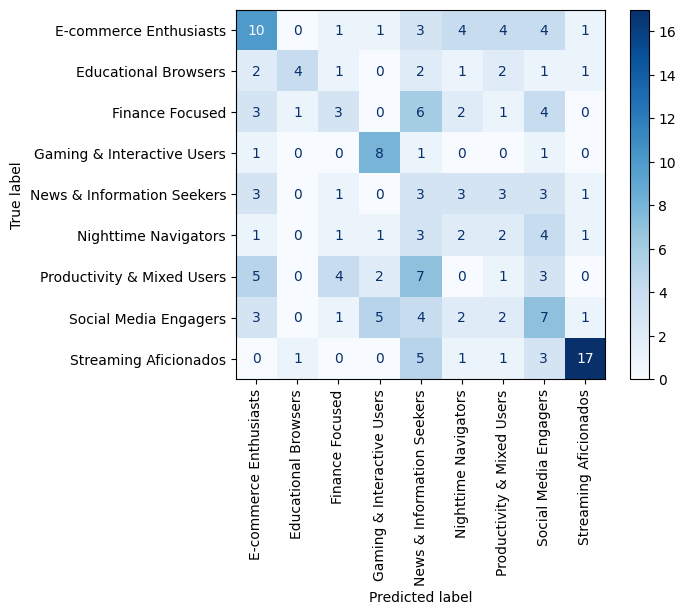

In [15]:
ConfusionMatrixDisplay.from_predictions(y, y_hat, xticks_rotation="vertical", cmap="Blues")
plt.show()

The confusion matrix shows how well the LLM maintains consistent persona assignments when presented with new browsing sequences from the same users. 

- Reasonably strong diagonal pattern indicates some consistency overall
- Some clear confusion between related personas (e.g., Educational/Productivity users)
- Most stable personas:
   - Streaming Aficionados
   - E-commerce Enthusiasts
   - Gaming & Interactive Users

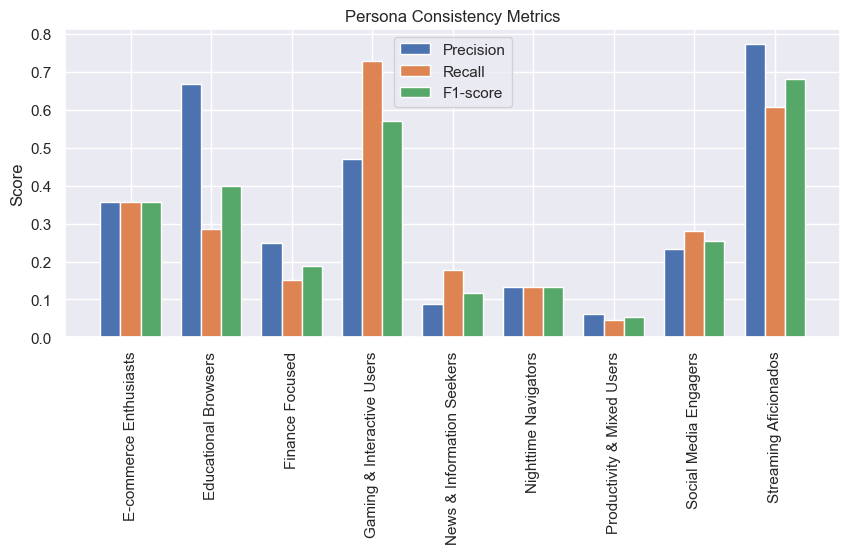

In [16]:
precision, recall, f1, support = precision_recall_fscore_support(y, y_hat)

sns.set()
plt.figure(figsize=(10, 4))
x = np.arange(len(list(personas.keys())))
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')
plt.xticks(x, list(personas.keys()), rotation=90)
plt.legend()
plt.ylabel("Score")
plt.title("Persona Consistency Metrics")
plt.show()